In [71]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, TimeDistributed, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [72]:
df = pd.read_csv("/kaggle/input/nvidia-stock-volatility-20142024/NVIDIA_Stock_Volatility_2014_2024.csv")
df.head()

,Date,Close,High,Low,Open,Volume,Daily_Return,Rolling_Volatility,ATR,Rolling_Mean,Upper_Band,Lower_Band
0,2014-01-31,0.370194,0.372316,0.365242,0.365478,335348000,-0.001272,0.016288,0.007461,0.372964,0.385216,0.360713
1,2014-02-03,0.365242,0.373259,0.363827,0.372787,431728000,-0.013376,0.016343,0.007293,0.372752,0.385398,0.360106
2,2014-02-04,0.367364,0.368071,0.363120,0.365006,280692000,0.005810,0.016091,0.006787,0.372398,0.385240,0.359557
3,2014-02-05,0.364063,0.365949,0.361233,0.364770,214676000,-0.008986,0.015657,0.006838,0.371573,0.384325,0.358821
4,2014-02-06,0.368779,0.369722,0.364063,0.364535,168380000,0.012953,0.015622,0.006990,0.370724,0.381627,0.359821


*Data preprocessing*

In [73]:
df.isnull().sum()

Date                  0
Close                 0
High                  0
Low                   0
Open                  0
Volume                0
Daily_Return          0
Rolling_Volatility    0
ATR                   0
Rolling_Mean          0
Upper_Band            0
Lower_Band            0
dtype: int64

In [74]:
df.describe()

,Close,High,Low,Open,Volume,Daily_Return,Rolling_Volatility,ATR,Rolling_Mean,Upper_Band,Lower_Band
count,2541.000000,2541.000000,2541.000000,2541.000000,2.541000e+03,2541.000000,2541.000000,2541.000000,2541.000000,2541.000000,2541.000000
mean,11.104996,11.293830,10.890524,11.094145,4.608275e+08,0.002584,0.026557,0.436025,10.809489,11.980233,9.638746
std,13.913558,14.133682,13.646661,13.891535,2.551542e+08,0.029373,0.012419,0.554386,13.240537,14.776951,11.758642
min,0.364063,0.365949,0.361233,0.364535,4.564400e+07,-0.187559,0.005627,0.006787,0.370724,0.381627,0.331451
25%,1.442168,1.459846,1.426946,1.444581,2.972020e+08,-0.011417,0.018016,0.033077,1.363935,1.462772,1.265097
50%,5.315171,5.403907,5.231772,5.331492,4.083040e+08,0.002386,0.023073,0.166488,5.273909,5.908683,4.773117
75%,15.393862,15.710562,15.107141,15.366314,5.552200e+08,0.016495,0.033729,0.657710,15.459655,17.437659,13.311766
max,88.679016,89.702776,87.009413,88.001183,3.692928e+09,0.298067,0.087022,3.650700,76.301127,88.341849,64.309604


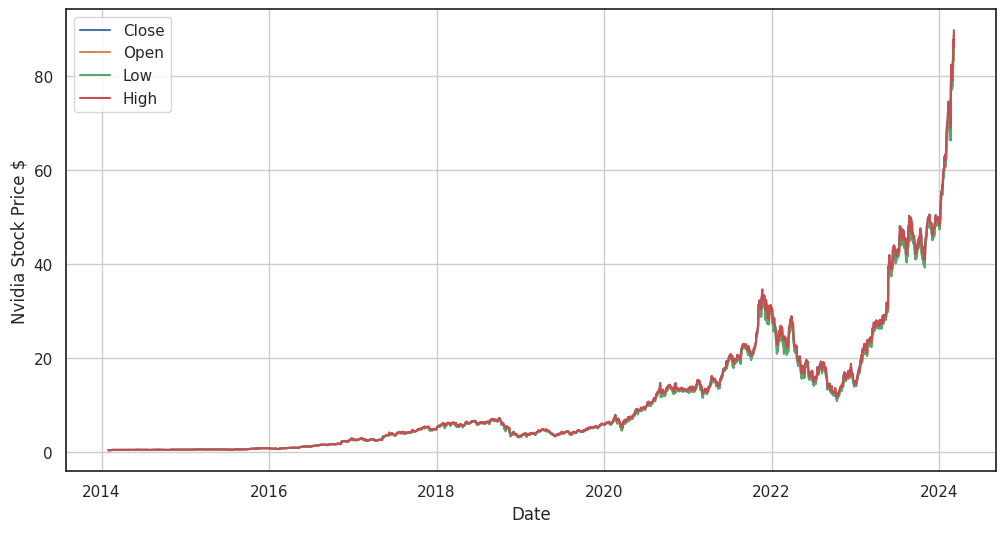

In [75]:
df['Date'] = pd.to_datetime(df['Date'])
# Plotting the open, close, high and low prices
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df["Close"], label= "Close")
plt.plot(df['Date'], df["Open"], label= "Open")
plt.plot(df['Date'], df["Low"], label= "Low")
plt.plot(df['Date'], df["High"], label= "High")
plt.xlabel('Date')
plt.ylabel('Nvidia Stock Price $')
plt.legend()
plt.grid(True)
plt.show()

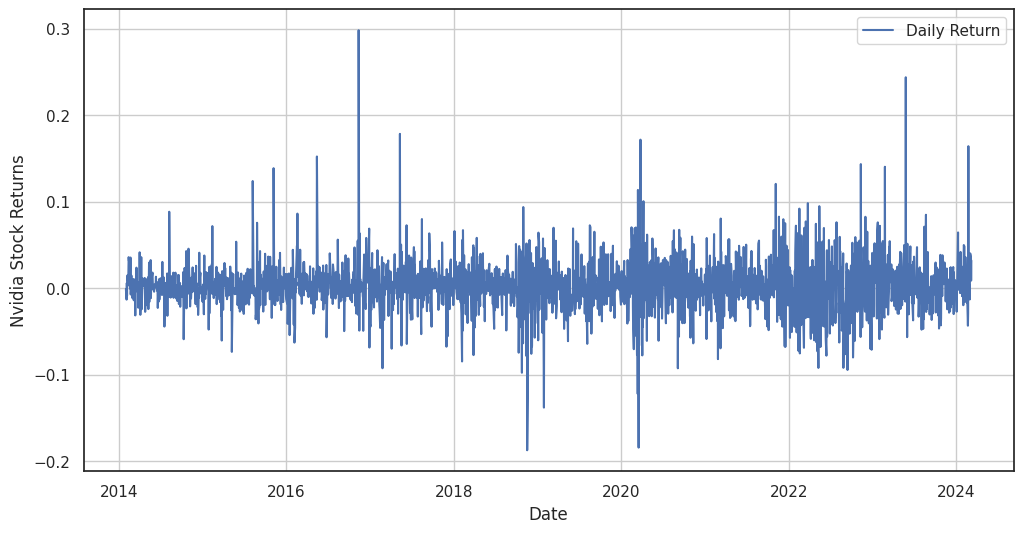

In [76]:
df['Date'] = pd.to_datetime(df['Date'])
# Plotting the open, close, high and low prices
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df["Daily_Return"], label= "Daily Return")
plt.xlabel('Date')
plt.ylabel('Nvidia Stock Returns')
plt.legend()
plt.grid(True)
plt.show()

In [77]:
df.columns

Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Daily_Return',
       'Rolling_Volatility', 'ATR', 'Rolling_Mean', 'Upper_Band',
       'Lower_Band'],
      dtype='object')

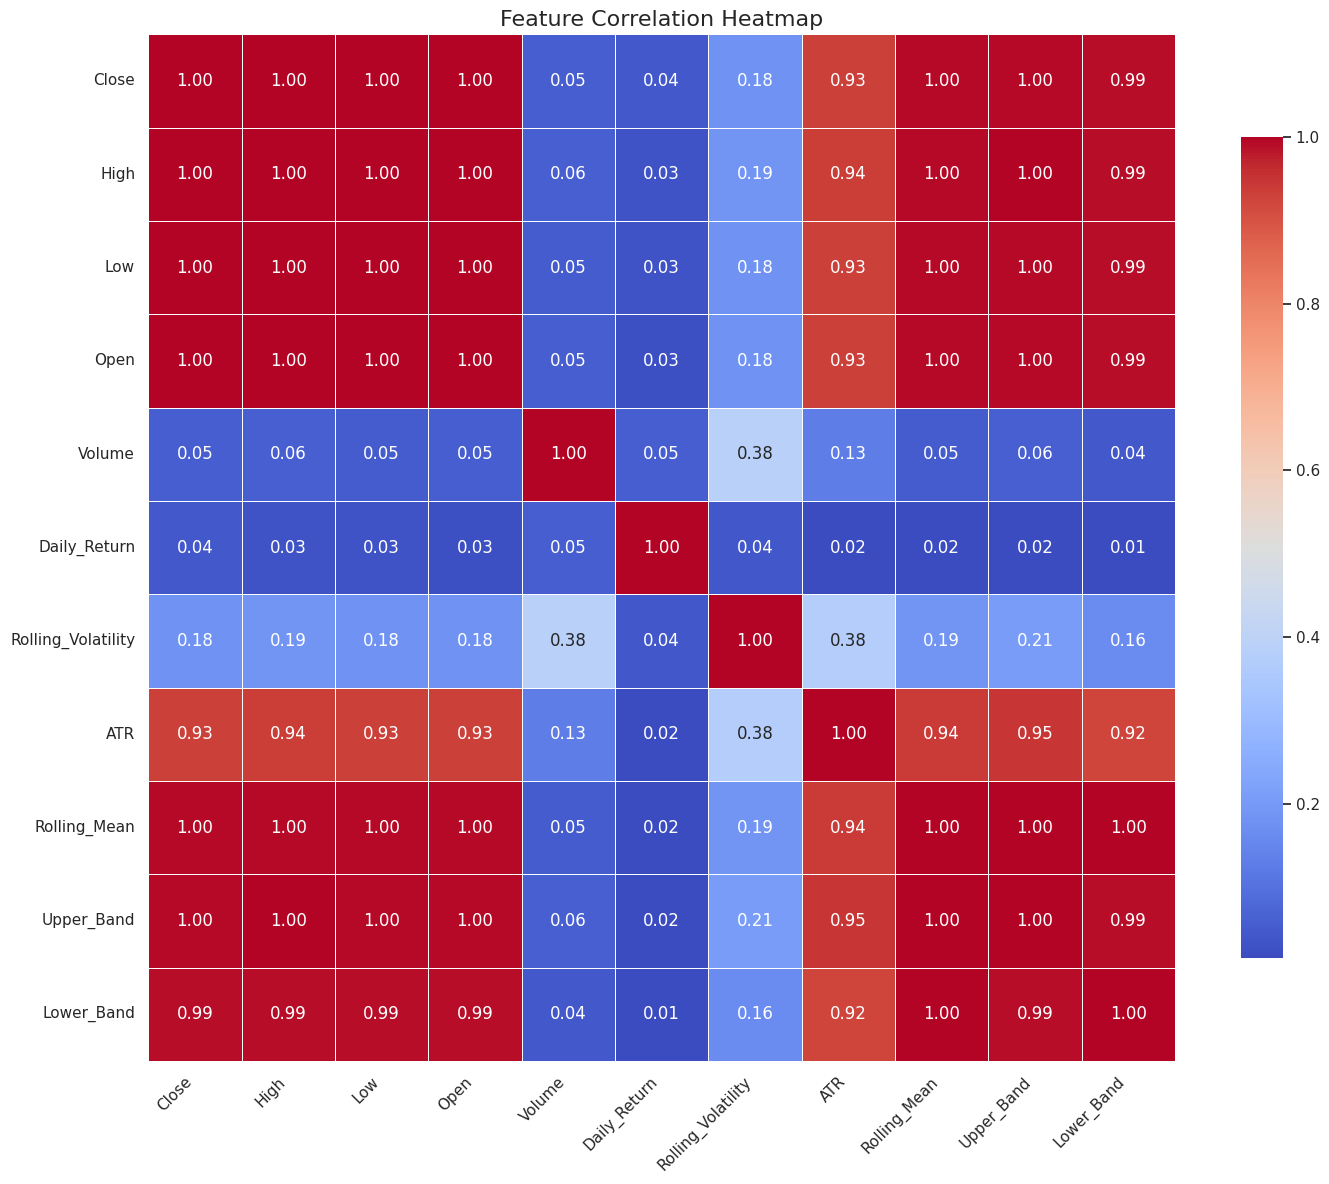

In [78]:
features = df[['Close', 'High', 'Low', 'Open', 'Volume', 'Daily_Return',
       'Rolling_Volatility', 'ATR', 'Rolling_Mean', 'Upper_Band',
       'Lower_Band']]
#Correlation between the financial metrics
plt.figure(figsize=(15, 12))
sns.set(style='white')
# Create heatmap
heatmap = sns.heatmap(features.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True,
                      linewidths=0.5, cbar_kws={'shrink': 0.8})
# Titles and formatting
plt.title('Feature Correlation Heatmap', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

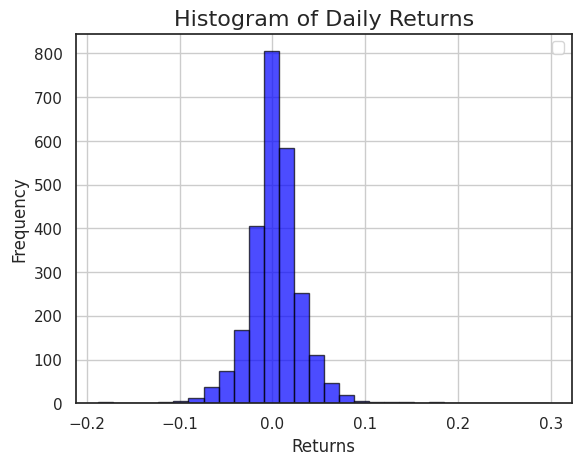

In [79]:
plt.hist(df["Daily_Return"], bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title("Histogram of Daily Returns", fontsize=16)
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

*Feature Scaling*

In [80]:
#Scale the closing price using MinMax
scaler = MinMaxScaler(feature_range=(0, 1))
data = df["Close"].values.reshape(-1, 1)
scaled_data = scaler.fit_transform(data)

In [81]:
def create_dataset(data, look_back):
            X, Y = [], []
            for i in range(look_back, len(data)):
                X.append(data[i - look_back:i, 0])  # Look-back period
                Y.append(data[i, 0])  # Target value
            return np.array(X), np.array(Y)

*Data split*

In [82]:
look_back= 60
X, y = create_dataset(scaled_data, look_back)

# Split into training and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Reshape input for CNN-LSTM
X_train = X_train.reshape(X_train.shape[0], look_back, 1, 1, 1)
X_val = X_val.reshape(X_val.shape[0], look_back, 1, 1, 1)
X_test = X_test.reshape(X_test.shape[0], look_back, 1, 1, 1)
X_train.shape, X_val.shape, X_test.shape

((1736, 60, 1, 1, 1), (372, 60, 1, 1, 1), (373, 60, 1, 1, 1))

In [83]:
# CNN-LSTM model with the specified architecture
cl = Sequential()
cl.add(TimeDistributed(Conv2D(filters=64, kernel_size=(1, 1), activation='relu'),
                               input_shape=(look_back, 1, 1, 1)))
cl.add(TimeDistributed(MaxPooling2D(pool_size=(1, 1))))
cl.add(TimeDistributed(Conv2D(filters=128, kernel_size=(1, 1), activation='relu')))
cl.add(TimeDistributed(MaxPooling2D(pool_size=(1, 1))))
cl.add(TimeDistributed(Conv2D(filters=64, kernel_size=(1, 1), activation='relu')))
cl.add(TimeDistributed(MaxPooling2D(pool_size=(1, 1))))
cl.add(TimeDistributed(Flatten()))
cl.add(Bidirectional(LSTM(100, return_sequences=True)))
cl.add(Dropout(0.5))
cl.add(Bidirectional(LSTM(100, return_sequences=False)))
cl.add(Dropout(0.5))
cl.add(Dense(1))
# Compile the model
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)
cl.compile(optimizer=optimizer, loss='mean_squared_error')
cl.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_21                  │ (None, 60, 1, 1, 64)        │             128 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_22                  │ (None, 60, 1, 1, 64)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_23                  │ (None, 60, 1, 1, 128)       │           8,320 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_24                  │ (None, 60, 1, 1, 128)       │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_25                  │ (None, 60, 1, 1, 64)        │           8,256 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_26                  │ (None, 60, 1, 1, 64)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_27                  │ (None, 60, 64)              │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 60, 200)             │         132,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 60, 200)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 200)                 │         240,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 389,705 (1.49 MB)

 Trainable params: 389,705 (1.49 MB)

 Non-trainable params: 0 (0.00 B)

In [84]:
# Fit the model
history = cl.fit(X_train,y_train,epochs=50,batch_size= 64,validation_data=(X_val, y_val),verbose=1)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 23s 184ms/step - loss: 0.0325 - val_loss: 0.0056
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0052 - val_loss: 5.6606e-04
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0014 - val_loss: 6.1949e-04
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0013 - val_loss: 4.1051e-04
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0011 - val_loss: 3.7557e-04
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0011 - val_loss: 3.6665e-04
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 8.7196e-04 - val_loss: 3.4217e-04
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0010 - val_loss: 2.9950e-04
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 8.6235e-04 - val_loss: 2.8430e-04
Epoch 10/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 8.4995e-04 - val_loss: 3.1613e-04
Epoch 11/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0011 - val_loss: 2.6262e-04
Epoch 12/

**Model Evaluation**

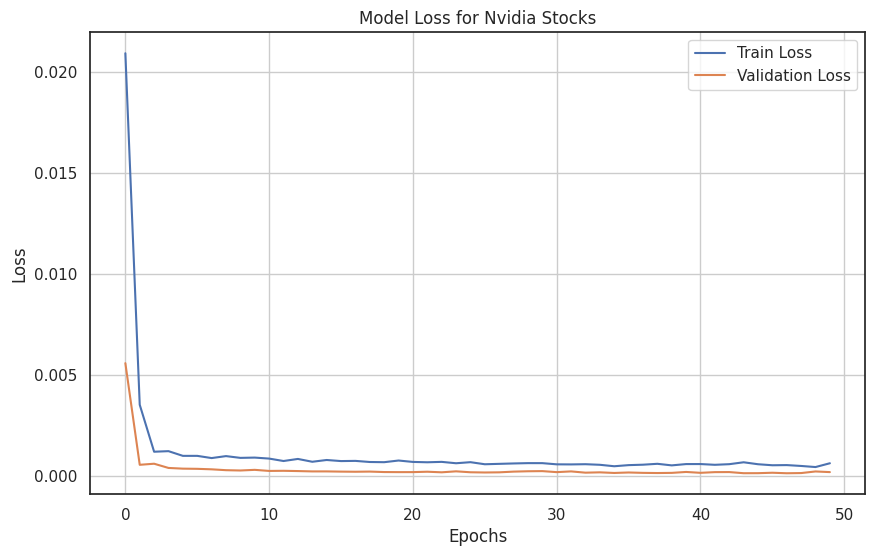

In [85]:
# Plot training & validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'Model Loss for Nvidia Stocks')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 327ms/step


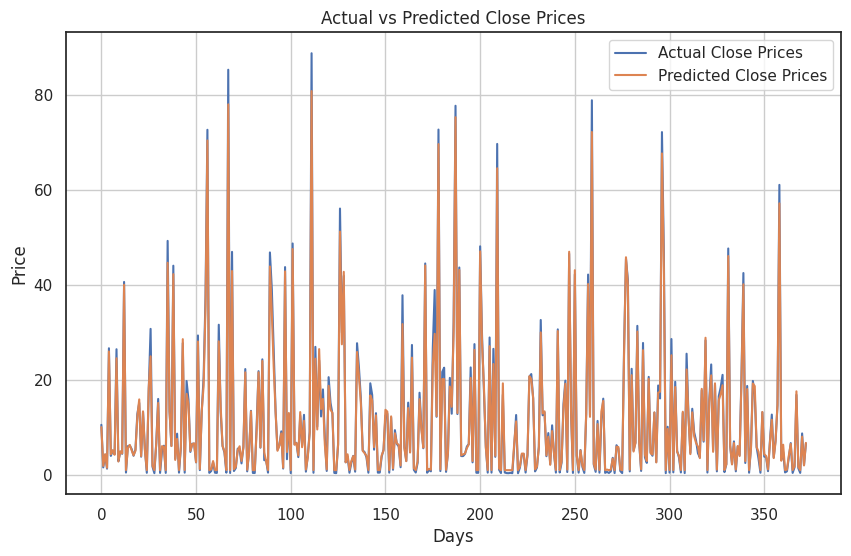

In [86]:
# Predictions
y_pred = cl.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
# Plot the Price prediciton 
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Actual Close Prices')
plt.plot(y_pred_inv, label='Predicted Close Prices')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [87]:
#Model metrics
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r_squared = r2_score(y_test_inv, y_pred_inv)
print(f"Model - RMSE: {rmse}, MAE: {mae}, R-squared: {r_squared}")

Model - RMSE: 1.4833530141010276, MAE: 0.8652889472869382, R-squared: 0.9909620874188751


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


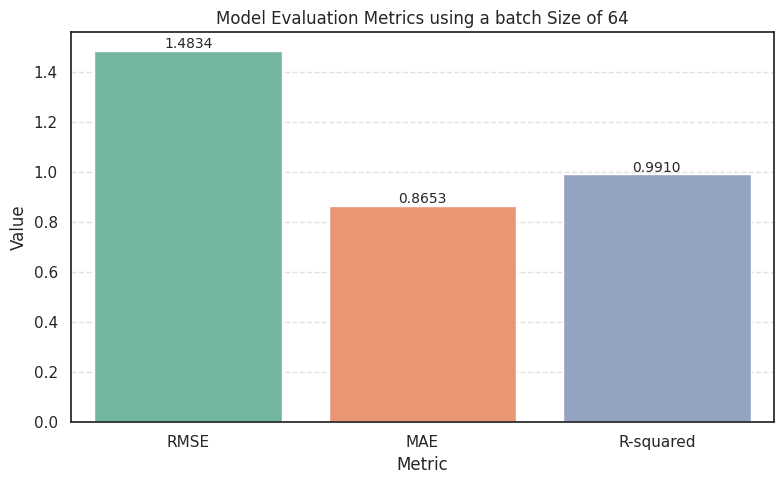

In [88]:
# List format metrics
metrics = ['RMSE', 'MAE', 'R-squared']
values = [rmse, mae, r_squared]  # Replace with your actual values
# Plotting the performance metrics
plt.figure(figsize=(8, 5))
sns.barplot(x=metrics, y=values, palette='Set2')
plt.title('Model Evaluation Metrics using a batch Size of 64')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.grid(axis='y', linestyle='--', alpha=0.6)
# Annotate values on top of bars
for i, val in enumerate(values):
    plt.text(i, val + 0.01, f'{val:.4f}', ha='center', fontsize=10)
plt.tight_layout()
plt.show()

**Increaing the batch-size to 128**

In [89]:
# CNN-LSTM model with the specified architecture
m2 = Sequential()
m2.add(TimeDistributed(Conv2D(filters=64, kernel_size=(1, 1), activation='relu'),
                               input_shape=(look_back, 1, 1, 1)))
m2.add(TimeDistributed(MaxPooling2D(pool_size=(1, 1))))
m2.add(TimeDistributed(Conv2D(filters=128, kernel_size=(1, 1), activation='relu')))
m2.add(TimeDistributed(MaxPooling2D(pool_size=(1, 1))))
m2.add(TimeDistributed(Conv2D(filters=64, kernel_size=(1, 1), activation='relu')))
m2.add(TimeDistributed(MaxPooling2D(pool_size=(1, 1))))
m2.add(TimeDistributed(Flatten()))
m2.add(Bidirectional(LSTM(100, return_sequences=True)))
m2.add(Dropout(0.5))
m2.add(Bidirectional(LSTM(100, return_sequences=False)))
m2.add(Dropout(0.5))
m2.add(Dense(1))
# Compile the model
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)
m2.compile(optimizer=optimizer, loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [90]:
# Fit the model
history = m2.fit(X_train,y_train,epochs=50,batch_size= 128,validation_data=(X_val, y_val),verbose=1)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 351ms/step - loss: 0.0263 - val_loss: 0.0053
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0068 - val_loss: 0.0027
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0032 - val_loss: 6.3647e-04
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0016 - val_loss: 7.0532e-04
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0014 - val_loss: 5.0501e-04
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0015 - val_loss: 4.2176e-04
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0012 - val_loss: 4.0050e-04
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0012 - val_loss: 3.7981e-04
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0011 - val_loss: 3.6449e-04
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0011 - val_loss: 3.4335e-04
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 7.6682e-04 - val_loss: 3.6744e-04
Epoch 12/50
14/14 ━━━

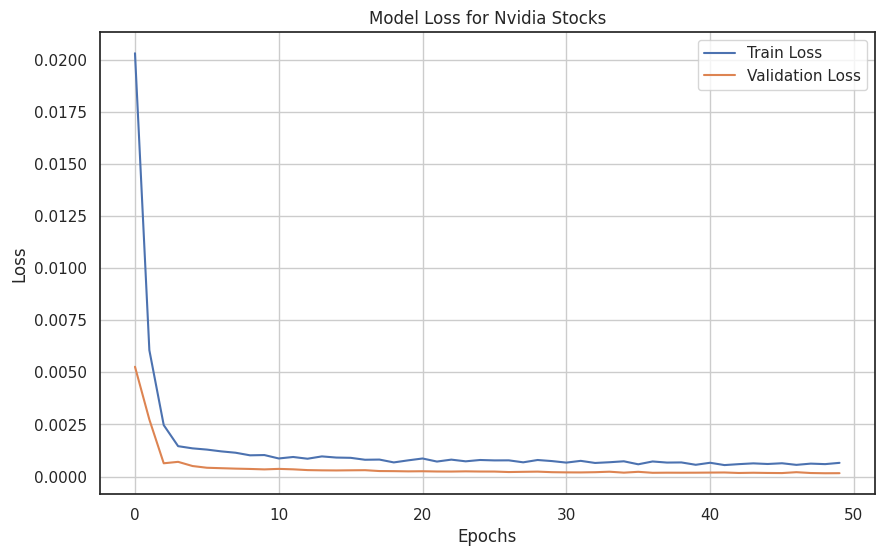

In [91]:
# Plot training & validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'Model Loss for Nvidia Stocks')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 329ms/step


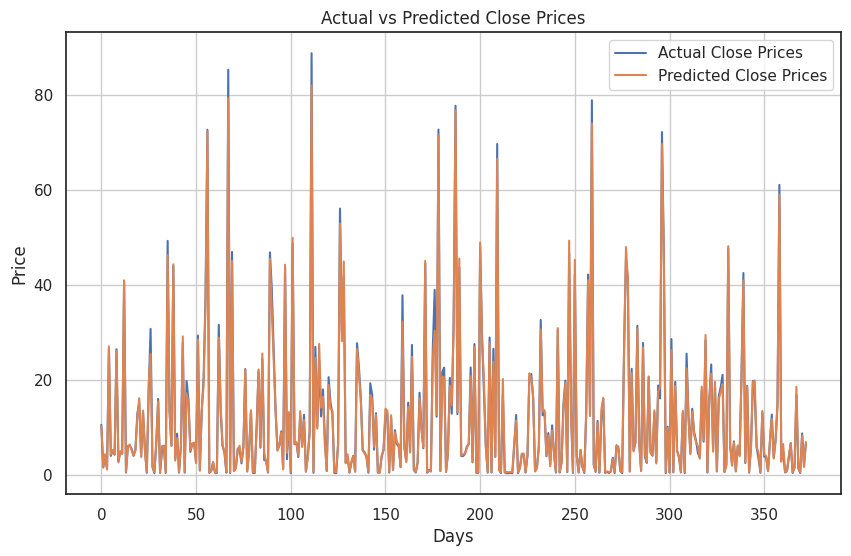

In [92]:
# Predictions
y_pred = m2.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
# Plot the Price prediciton 
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Actual Close Prices')
plt.plot(y_pred_inv, label='Predicted Close Prices')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [93]:
#Model metrics
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r_squared = r2_score(y_test_inv, y_pred_inv)
print(f"Model - RMSE: {rmse}, MAE: {mae}, R-squared: {r_squared}")

Model - RMSE: 1.24452840595537, MAE: 0.6842258912948117, R-squared: 0.9936380723351746


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


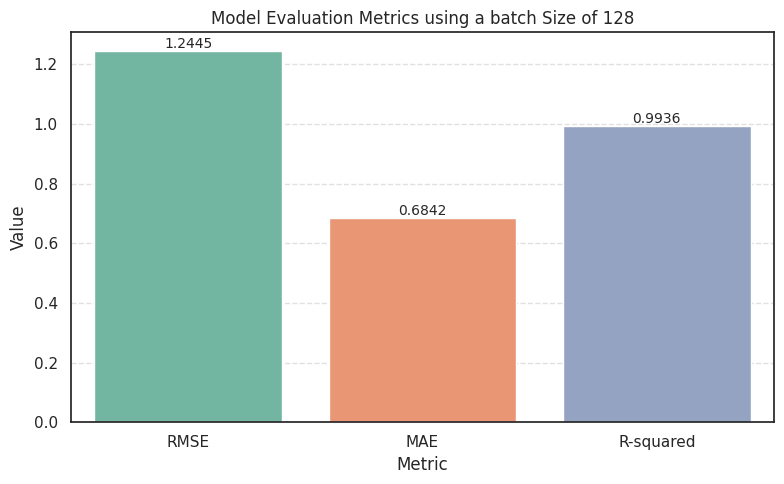

In [94]:
# List format metrics
metrics = ['RMSE', 'MAE', 'R-squared']
values = [rmse, mae, r_squared]  # Replace with your actual values
# Plotting the performance metrics
plt.figure(figsize=(8, 5))
sns.barplot(x=metrics, y=values, palette='Set2')
plt.title('Model Evaluation Metrics using a batch Size of 128')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.grid(axis='y', linestyle='--', alpha=0.6)
# Annotate values on top of bars
for i, val in enumerate(values):
    plt.text(i, val + 0.01, f'{val:.4f}', ha='center', fontsize=10)
plt.tight_layout()
plt.show()

*Batch size of 256*

In [95]:
# CNN-LSTM model with the specified architecture
m3 = Sequential()
m3.add(TimeDistributed(Conv2D(filters=64, kernel_size=(1, 1), activation='relu'),
                               input_shape=(look_back, 1, 1, 1)))
m3.add(TimeDistributed(MaxPooling2D(pool_size=(1, 1))))
m3.add(TimeDistributed(Conv2D(filters=128, kernel_size=(1, 1), activation='relu')))
m3.add(TimeDistributed(MaxPooling2D(pool_size=(1, 1))))
m3.add(TimeDistributed(Conv2D(filters=64, kernel_size=(1, 1), activation='relu')))
m3.add(TimeDistributed(MaxPooling2D(pool_size=(1, 1))))
m3.add(TimeDistributed(Flatten()))
m3.add(Bidirectional(LSTM(100, return_sequences=True)))
m3.add(Dropout(0.5))
m3.add(Bidirectional(LSTM(100, return_sequences=False)))
m3.add(Dropout(0.5))
m3.add(Dense(1))
# Compile the model
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)
m3.compile(optimizer=optimizer, loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [96]:
# Fit the model
history = m3.fit(X_train,y_train,epochs=50,batch_size= 256,validation_data=(X_val, y_val),verbose=1)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 706ms/step - loss: 0.0368 - val_loss: 0.0226
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - loss: 0.0269 - val_loss: 0.0150
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.0181 - val_loss: 0.0096
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.0132 - val_loss: 0.0084
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.0101 - val_loss: 0.0059
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.0065 - val_loss: 0.0025
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.0030 - val_loss: 8.2867e-04
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.0014 - val_loss: 6.9355e-04
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.0015 - val_loss: 8.0956e-04
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 0.0013 - val_loss: 6.2048e-04
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.0013 - val_loss: 5.2471e-04
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - lo

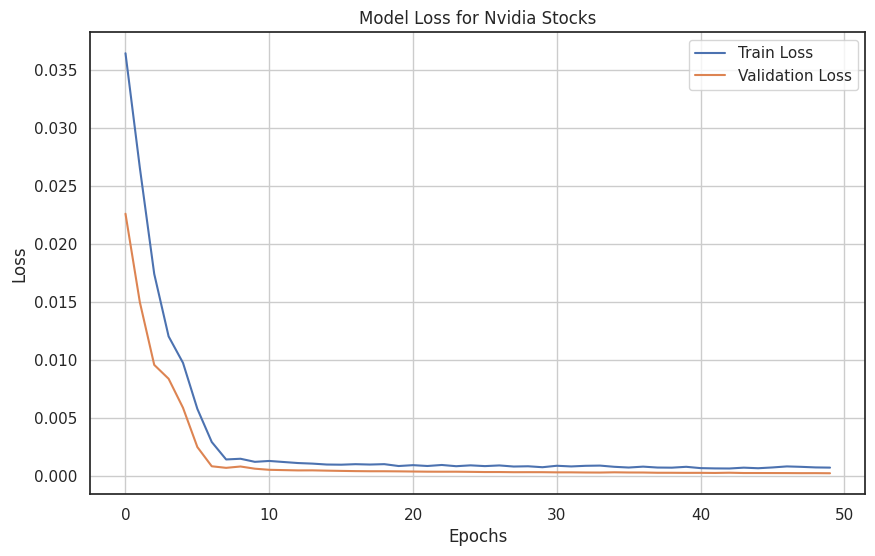

In [97]:
# Plot training & validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'Model Loss for Nvidia Stocks')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 326ms/step


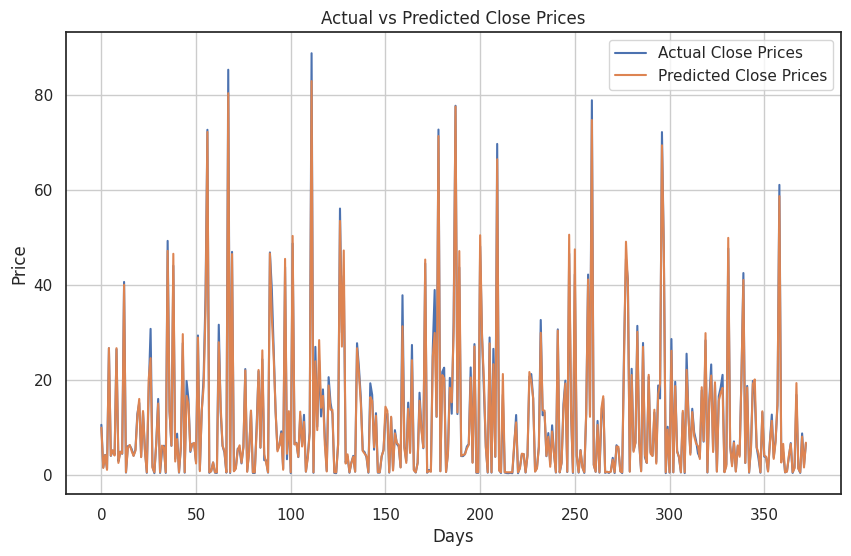

In [98]:
# Predictions
y_pred = m3.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
# Plot the Price prediciton 
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Actual Close Prices')
plt.plot(y_pred_inv, label='Predicted Close Prices')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [99]:
#Model metrics
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r_squared = r2_score(y_test_inv, y_pred_inv)
print(f"Model - RMSE: {rmse}, MAE: {mae}, R-squared: {r_squared}")

Model - RMSE: 1.4345186236597218, MAE: 0.7897012332808876, R-squared: 0.9915473773504637


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


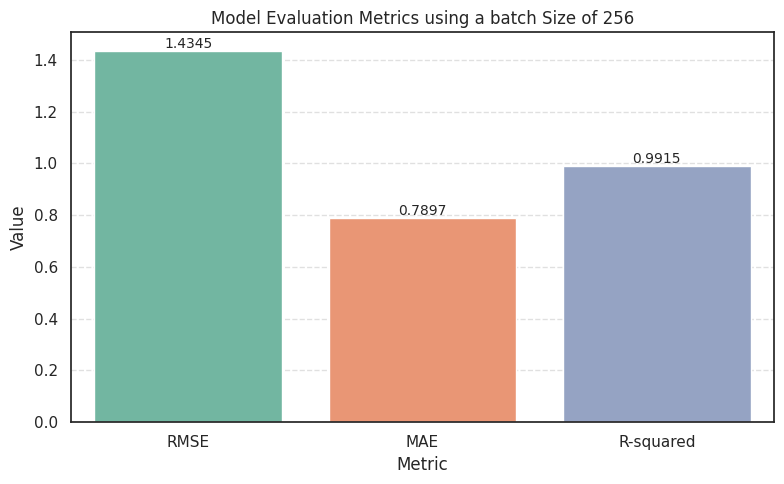

In [100]:
# List format metrics
metrics = ['RMSE', 'MAE', 'R-squared']
values = [rmse, mae, r_squared]  # Replace with your actual values
# Plotting the performance metrics
plt.figure(figsize=(8, 5))
sns.barplot(x=metrics, y=values, palette='Set2')
plt.title('Model Evaluation Metrics using a batch Size of 256')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.grid(axis='y', linestyle='--', alpha=0.6)
# Annotate values on top of bars
for i, val in enumerate(values):
    plt.text(i, val + 0.01, f'{val:.4f}', ha='center', fontsize=10)
plt.tight_layout()
plt.show()